In [4]:
%matplotlib inline
from __future__ import division, print_function
import matplotlib as mpl
mpl.style.use('classic')
import matplotlib.pyplot as plt
import numpy as np
import h5py
from scipy import signal, linalg
from ipywidgets import interact

In [5]:
import sklearn
from scipy import linalg, signal, optimize
import lockin
import phasekick2 as pk2
import phasekick as pk
import tqdm
import sigutils
import munch
%reload_ext timedomainfit
from timedomainfit import *
import timedomainfit as td

def dc_term(t_, tau, t0, dx):
    t = t_ - t0
    omega = 61.84 * 2 * np.pi
    omega_tau2 = (omega * tau)**2
    x_light =(dx * (1 - omega_tau2 / (1 + omega_tau2) * np.exp(-t/tau)) - 
              dx / (1 + omega_tau2) * (np.cos(omega * t) + omega * tau * np.sin(omega*t))
              )
    return np.where(t > 0, x_light, 0)

def dc_plus_ac(t_, tau, t0, dx, X0, Y0, tau_df):
    t = t_ - t0
    omega = 61.84 * 2 * np.pi
    omega_tau2 = (omega * tau)**2
    phi = pk.phase_step(t, tau_df, 1)
    x_light = (dx * (1 - omega_tau2 / (1 + omega_tau2) * np.exp(-t/tau)) - 
              dx / (1 + omega_tau2) * (np.cos(omega * t) + omega * tau * np.sin(omega*t))
              )
    x_df = X0 * phi * np.cos(t*omega) + Y0 * phi * np.sin(t*omega)
    return np.where(t > 0, x_light + x_df, 0)

def dc_induced_ac(t_, tau, t0, dx, X0, Y0, tau_df):
    t = t_ - t0
    omega = 61.84 * 2 * np.pi
    omega_tau2 = (omega * tau)**2
    return - dx / (1 + omega_tau2) * (np.cos(omega * t) + omega * tau * np.sin(omega*t))

In [6]:
mpl.rc('font', size='9')

In [7]:
# phit, optfunc, optfuncQ, optfuncDC, optfuncDet, xDCt, xDC_all = td.make_optfunc(t0=0, tp=1.4e-3)

In [8]:
fh = h5py.File("../data/tr-efm/151218-003450-100sun-784.h5", "r")
params =   {'fp': 4000,
             'fc': 15000,
             't_phase': -0.052,
             'ti': -54e-3,
             'tf': 6e-3,
             'Ndec': 1}
fir = lockin.lock2(66000, params['fp'], params['fc'], fs=1e6)

Response:
f   mag       dB
    0.000 1.000    0.000
 2000.000 0.982   -0.161
 4000.000 0.921   -0.715
15000.000 0.098  -20.164
30000.000 0.000 -101.125
33000.000 0.000 -110.366
66000.000 0.000 -141.187
500000.000 0.000 -196.320


In [9]:
b = td.signal_average_gr_parab(fh['data'], -1.5e-3, 0, invert=False)

Response:
f   mag       dB
    0.000 1.000    0.000
 3091.925 0.983   -0.152
 6183.850 0.927   -0.658
24735.399 0.095  -20.423
30919.249 0.011  -38.978
49470.798 0.000 -101.893
61838.498 0.000 -110.800
500000.000 0.000 -337.181


In [10]:
p0 = np.array([-23, 30, 61.850, 0.01, 0.0])
bdamp = fit_damped_sine_eliminate_harmonics(b.t_ms, b.x, p0)

In [11]:
b2 = td.signal_average_gr_parab(fh['data'], -1.5e-3, 1.4e-3, invert=False)

Response:
f   mag       dB
    0.000 1.000    0.000
 3091.589 0.983   -0.152
 6183.178 0.927   -0.658
24732.713 0.095  -20.422
30915.891 0.011  -38.973
49465.425 0.000 -101.894
61831.782 0.000 -110.805
500000.000 0.000 -342.271


In [12]:
remove_harmonics(b2, bdamp)

In [14]:
bi = td.signal_average_gr_parab(fh['data'], -1.5e-3, 0, invert=False, align_voltage=True)

Response:
f   mag       dB
    0.000 1.000   -0.000
 3099.931 0.983   -0.152
 6199.861 0.927   -0.660
24799.444 0.096  -20.369
30999.305 0.011  -38.830
49598.888 0.000 -101.957
61998.610 0.000 -110.975
500000.000 0.000 -179.337


In [15]:
bidamped = fit_damped_sine_eliminate_harmonics(bi.t_ms, bi.x, p0=np.array([0, 0, 62.0, 0.0, 0.0]))

In [16]:
bi_all = td.signal_average_gr_parab(fh['data'], -1.5e-3, 1.4e-3, invert=False, align_voltage=True)

Response:
f   mag       dB
    0.000 1.000   -0.000
 3096.811 0.983   -0.152
 6193.623 0.927   -0.661
24774.492 0.096  -20.354
30968.115 0.011  -38.789
49548.983 0.000 -101.976
61936.229 0.000 -111.030
500000.000 0.000 -179.312


In [17]:
remove_harmonics(bi_all, bidamped)

In [34]:
fh2 = h5py.File("../data/tr-efm/151217-234238-20sun-df-384.h5", "r")
b1s = td.signal_average_gr_parab(fh2['data'], -1.5e-3, 0, invert=False)

b1s_all = td.signal_average_gr_parab(fh2['data'], -1.5e-3, 1.4e-3, invert=False)
b1sdamped = td.fit_damped_sine_eliminate_harmonics(b1s.t_ms, b1s.x, p0=np.array([0, 0, 61.85, 0.01, 0.0]))
remove_harmonics(b1s_all, b1sdamped)

Response:
f   mag       dB
    0.000 1.000    0.000
 3092.013 0.983   -0.152
 6184.027 0.927   -0.658
24736.106 0.095  -20.424
30920.133 0.011  -38.979
49472.212 0.000 -101.892
61840.265 0.000 -110.799
500000.000 0.000 -343.154


Response:
f   mag       dB
    0.000 1.000    0.000
 3091.919 0.983   -0.152
 6183.837 0.927   -0.658
24735.349 0.095  -20.423
30919.187 0.011  -38.977
49470.699 0.000 -101.893
61838.373 0.000 -110.800
500000.000 0.000 -337.185


In [21]:
# plt.savefig('../../figs/SI-151-residuals.pdf', bbox_inches='tight')

In [36]:
m = pk.masklh(b2.t_us, -10, 180)
popt, pcov = optimize.curve_fit(dc_term, b2.t_ms[m], b2.resid[m], p0=np.array([0.050, 0.008, 1.4]))

In [37]:
popt2, pcov2 = optimize.curve_fit(dc_plus_ac, b2.t_ms[m], b2.resid[m], p0=np.r_[0.05, 0.008, 0.7, 0, 0, 0.05])

In [39]:
A0 = abs(bdamp.fit.popt[0] + bdamp.fit.popt[1]*1j)

In [40]:
# plt.figure(figsize=(6.5, 2.5))
# plt.plot(b2.t_us, b2.x_no_overtones, linewidth=0.5, color='0.5')
# plt.plot(b2.t_us, b2.x_no_overtones, '.')
# plt.xlim(-12, 120)
# plt.ylim(-42.2, 42.2)
# plt.xlabel(u"Time $t$ [µs]")
# plt.ylabel(u'Displacement $x$ [nm]')
# plt.savefig('../../figs/SI-150-x-vs-t.pdf', bbox_inches='tight')

/Users/ryandwyer/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:50: RuntimeWarning: overflow encountered in expm1


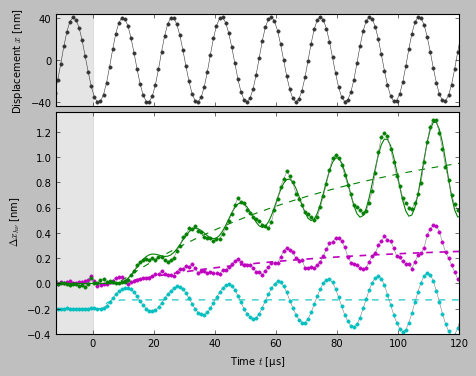

In [42]:
t = bi_all.t_us
# plt.plot(t, bi_all.resid, '-', linewidth=0.5, color='0.5')
# plt.plot(t, bi_all.resid, '.',)
fig = plt.figure(figsize=(6.5, 5))
gs = mpl.gridspec.GridSpec(10, 1)
ax1 = fig.add_subplot(gs[:3])

ax1.axvspan(-12, 0, color='0.8', zorder=0, alpha=0.5)

ax1.plot(b2.t_us, b2.x, linewidth=0.5, color='0.2')
ax1.plot(b2.t_us, b2.x, '.', color='0.2')

plt.xlim(-12, 120)
plt.ylim(-44, 44)
ax1.set_yticks(np.arange(-40, 41, 40))
plt.xlabel(u"Time $t$ [µs]")
plt.ylabel(u'Displacement $x$ [nm]')

ax2 = fig.add_subplot(gs[3:])

ax2.plot(t, bi_all.resid*0.05-0.2, '-', linewidth=0.5, color='0.5')
ax2.plot(t, bi_all.resid*0.05-0.2, '.', color='c')

ax2.plot(t, b1s_all.resid, '-', linewidth=0.5, color='0.5')
ax2.plot(t, b1s_all.resid, '.', color='m')

m = pk.masklh(b1s_all.t_us, -10, 180)
dc = lambda t, dx, tau: np.where(t > 8.0, -dx * np.expm1(-(t-8)/tau), 0)
popt1, pcov1 = optimize.curve_fit(dc, b1s_all.t_us[m], b1s_all.resid[m],
                                  p0=np.array([0.3, 60]))

# ax2.plot(b2.t_us[m], dc_term(b2.t_ms[m], *popt2[:3]))
# ax2.plot(b2.t_us[m], dc_term(b2.t_ms[m], *popt2[:3]))
# ax2.plot(b2.t_us[m], dc_plus_ac(b2.t_ms[m], *popt2))

ax2.plot(b2.t_us[m], dc_plus_ac(b2.t_ms[m], *popt2), color='g')
plt.plot(t, dc(t, 0.3, 60), 'm--', linewidth=1.5, zorder=0)
# plt.plot(t, dc(t, 0.4433, 106.6), 'm--', linewidth=1, zorder=0)

plt.axvspan(-12, 0, color='0.8', zorder=0, alpha=0.5)

t = b2.t_us

# plt.plot(t, b2.x_no_overtones*0.004-0.33, '.', color='0.5')
# plt.plot(t, b2.x_no_overtones*0.004-0.33, '-', color='0.5', alpha=0.5)

plt.plot(t, b2.resid, '-', linewidth=0.5, color='0.5')
plt.plot(t, b2.resid, 'g.',)
m = pk.masklh(t, -10, 180)
dc = lambda t, dx, tau: np.where(t > 8.0, -dx * np.expm1(-(t-8)/tau), 0)
popt, pcov = optimize.curve_fit(dc, t[m], b2.resid[m],
                                p0=np.array([1, 20]))
plt.plot(t, dc(t, *popt), 'g--', linewidth=1, zorder=0)
plt.plot(t, dc(t+5, 0.07, 1.5) - 0.2, 'c--', linewidth=1)
plt.xlim(-12, 120)
plt.ylim(-0.4, 1.36)
plt.ylabel(' $\\Delta x_{h \\nu}$ [nm]')
plt.xlabel(u"Time $t$ [µs]")
ax1.set_xticklabels([''])



In [43]:
fig.savefig('../figs/SI-151-residuals.pdf', bbox_inches='tight')

In [44]:
1/(300 * 2 * np.pi) * 1e6

530.5164769729845

In [45]:
pcov2.diagonal()**0.5 * np.array([1e3, 1e3, 1, 1, 1, 1e3])

array([ 1.90878442,  0.44318186,  0.01223615,  0.14812707,  0.74344493,
        4.31803501])

In [47]:
# !open ../../figs/SI-151-residuals.pdf

In [48]:
# !cp ../../figs/SI-151-residuals.pdf /Users/ryandwyer/Dropbox/_JAM_MS__Dwyer201511__Phasekick__figs/SI/

In [49]:
bi_all.fit_all = td.record_fit(td.damped_sine_exp, bi.t_ms, bi.x, p0=np.array([40, 0, 62.0, 0, 0, -0.12, 10.0, 0.0]))

/Users/ryandwyer/anaconda/lib/python2.7/site-packages/scipy/optimize/minpack.py:779: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


In [52]:
A = td.harNphi(td._damped_sine_exp_phi(bi_all.t_ms, *bi_all.fit_all.popt),
            5,
            td._damped_sine_exp_A(bi_all.t_ms, *bi_all.fit_all.popt)
            )

In [54]:
bi_all.fit_all = td.record_fit(td.damped_sine_exp, bi_all.t_ms, bi_all.x, p0=np.array([40, 0, 62.0, 0, 0, -0.12, 10.0, 0.0]))

In [55]:
td.damped_sine_exp(bi_all.t_ms, *np.array([-4.32917325e+01,  -1.44660161e+01,   6.19986306e+01,
        -2.43226565e-04,  -8.79504450e-04, 0, 0, 0]))
td.damped_sine_exp(bi_all.t_ms, *bi_all.fit_all.popt)

array([-42.83801124, -45.08760234, -40.56726905, ...,  31.58833294,
        42.73567736,  47.52194947])

In [56]:
omega_tau = (popt2[0] * (2*np.pi*bdamp.fit.popt[2]))

In [57]:
abs((1 + 1j * omega_tau) / bdamp.fit.popt[2])

0.43587603140731185

In [58]:
(1/np.sqrt(1 + omega_tau**2) * 1.16) / 42

0.0010246431845289394

In [59]:
(popt2[2]/np.sqrt(1 + omega_tau**2)) / abs(bdamp.fit.popt[0] + bdamp.fit.popt[1]*1j) / (2*np.pi) * 1e3

0.16515347453976778

In [60]:
(popt2[2]/np.sqrt(1 + omega_tau**2))

0.042932276282298815

In [61]:
0.165 * 0.058

0.00957

In [62]:
abs(bdamp.fit.popt[0] + bdamp.fit.popt[1]*1j)

41.372935129315046

In [63]:
sum(bdamp.fit.pcov[:2, :2].diagonal())**0.5

0.0021054833296064055

In [64]:
4/69

0.057971014492753624